# WGAN-GP on MNIST 

### 本章節內容大綱
* [WGAN-GP原理](#WGAN-GP原理)
* [使用 Gradient penalty 取代 weight clipping](#使用-Gradient-penalty-取代-weight-clipping)

# WGAN-GP原理

WGAN用了比較粗糙的作法——weight clipping，讓discriminator變得平滑而接近1-Lipschitz function，然而這種做法有以下兩點問題：<br>
第一、最後Discriminator的參數很容易收斂到clipping範圍的兩個邊界值，只能學習出簡單的function

<br>
<img src='https://hackmd.io/_uploads/Hye-8m-eT.jpg'>
<br>

第二、很容易因為clipping範圍些微差異的設定，在Discriminator network各層間出現梯度爆炸或梯度消失

<br>
<img src='https://hackmd.io/_uploads/r1JBI7-gT.jpg'>
<br>

所以之後就有了改良版——WGAN-GP(gradient penalty)，取代了weight clipping，WGAN-GP將Wasserstein distance改成下式：

$$W(P_{data}, P_G) = \max_D (E_{x\sim P_{data}}\; [D(x)] - E_{x\sim P_G}\;[D(x)] - \lambda E_{x\sim P_{penalty}}\;\;[max(0,||\nabla_x D(x)|| -1)])$$

因為$||\nabla_x D(x)|| \leq 1$ (Discriminator 對 input 的 gradient 小於或等於 1)就等價於 1-Lipschitz function ，所以 WGAN-GP 就加上了 discriminator gradient 減去 1 的懲罰項以近似 1-Lipschitz function ，然而實際實驗過後，作者將其改寫成下式（將其 gradient 接近 1），訓練效果會更好：

$$W(P_{data}, P_G) = \max_D (E_{x\sim P_{data}}\; [D(x)] - E_{x\sim P_G}\;[D(x)] - \lambda E_{x\sim P_{penalty}}\;\;[(||\nabla_x D(x)|| -1)^2])$$

其中 lambda 是 penalty weight，P_penalty 是在真實資料與生成資料之中 sample 資料，對其 gradient 作懲罰即可，而不需要對整個 data space 都作 graident。

# Import 

In [1]:
''' basic package '''
import os
import time
import imageio
import glob
from IPython.display import display, Image

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Conv2DTranspose, Conv2D, BatchNormalization,
    LeakyReLU, Dropout, Reshape, Flatten
)

from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.optimizers import Adam, RMSprop

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Config 

In [3]:
BATCH_SIZE = 128
BUFFER_SIZE = 60000
z_dim = 100
EPOCHS = 200
learning_rate = 1e-4
num_examples_to_generate = 16
gp_weight = 10

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Train 

### 定義 generator & discriminator 

In [4]:
# Define model


class Generator(Model):
    def __init__(self, z_dim):
        super(Generator, self).__init__()

        self.model = Sequential()

        # [z_dim] => [7, 7, 128]
        self.model.add(Dense(7 * 7 * 128, use_bias=False, input_shape=(z_dim,)))
        self.model.add(LeakyReLU())
        self.model.add(Reshape((7, 7, 128)))

        # [7, 7, 128] => [14, 14, 64]
        self.model.add(Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False))
        self.model.add(LeakyReLU())

        # [14, 14, 64] => [28, 28, 1]
        self.model.add(Conv2DTranspose(1, 5, strides=2, padding='same', activation='tanh', use_bias=False))

    def call(self, x):
        return self.model(x)


class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = Sequential()

        # [28, 28, 1] => [14, 14, 64]
        self.model.add(Conv2D(64, 5, strides=2, padding='same', input_shape=(28, 28, 1)))
        self.model.add(LeakyReLU())

        # [14, 14, 64] => [7, 7, 128]
        self.model.add(Conv2D(128, 5, strides=2, padding='same'))
        self.model.add(LeakyReLU())

        # [7, 7, 128] => [4, 4, 256]
        self.model.add(Conv2D(256, 5, strides=2, padding='same'))
        self.model.add(LeakyReLU())

        # [4, 4, 256] => [1]
        self.model.add(Flatten())
        self.model.add(Dense(1))

    def call(self, x):
        return self.model(x)

# 使用 Gradient penalty 取代 weight clipping

跟WGAN或Vanilla GAN的最大差異就是在loss function中多了gradient penalty，基本上就是從真實資料與生成資料中sample資料，然後對discriminator作gradient descend後得到該資料點上的graident，取完norm後減一再平方就是我們要的gradient penalty了！

<br>
<img src="https://hackmd.io/_uploads/BJxwL7bxa.jpg" width=500  />

In [5]:
def gradient_penalty(real_images, fake_images):

    # 先從 0 ~ 1 隨機 sample 一組權重(shape 必須與圖片的 tensor 吻合)
    epsilon = tf.random.uniform([real_images.shape[0], 1, 1, 1], 0.0, 1.0)

    # 將權重乘上一組真資料與假資料，這樣就等同於從真假資料之間 sample 一筆資料
    x_hat = epsilon * real_images + (1 - epsilon) * fake_images

    with tf.GradientTape() as t:
        # watch 這個 method 是確保 tape 能夠指認要微分的對象
        t.watch(x_hat)
        d_hat = discriminator(x_hat)
    gradients = t.gradient(d_hat, x_hat)

    # 先取 gradient 的 norm ， 減一後再平方
    g_norm = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
    gradient_penalty = tf.reduce_mean((g_norm - 1.0) ** 2)
    return gradient_penalty


def gan_loss(d_real_output, d_fake_output, real_images, fake_images):

    # 與vanilla GAN 不同的地方是不加 log 而是直接用 output 來算gradient

    # discriminator loss
    d_loss = tf.reduce_mean(d_fake_output) - tf.reduce_mean(d_real_output) + gradient_penalty(
        real_images, fake_images) * gp_weight

    # generator loss
    g_loss = tf.reduce_mean(-d_fake_output)
    return d_loss, g_loss

# Model, seed and checkpoint setting

In [6]:
generator = Generator(z_dim)
discriminator = Discriminator()

g_optimizer = RMSprop(learning_rate)
d_optimizer = RMSprop(learning_rate)

seed = tf.random.normal([num_examples_to_generate, z_dim])

save_dir = './saved_imgs_GP'
checkpoint_dir = './training_checkpoints_GP'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(g_optimizer=g_optimizer,
                                 d_optimizer=d_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [7]:
@tf.function
def train_step(real_images, generator, discriminator, g_optimizer, d_optimizer):
    noise = tf.random.normal([real_images.shape[0], z_dim])
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_images = generator(noise, training=True)
        d_real_logits = discriminator(real_images)
        d_fake_logits = discriminator(fake_images)

        d_loss, g_loss = gan_loss(d_real_logits, d_fake_logits, real_images, fake_images)

    g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
    d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

    return d_loss, g_loss

In [8]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            d_loss, g_loss = train_step(image_batch, generator, discriminator, g_optimizer, d_optimizer)

        # Produce images
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
        print('discriminator loss: %.5f' % d_loss)
        print('generator loss: %.5f' % g_loss)
        generate_and_save_images(generator, epoch + 1, seed, save_dir)

        # Save the model every 25 epochs
        if (epoch + 1) % 25 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    # generating / saving after the final epoch
    generate_and_save_images(generator, epochs, seed, save_dir)
    checkpoint.save(file_prefix=checkpoint_prefix)

In [9]:
def generate_and_save_images(model, epoch, test_input, save_path):

    predictions = model(test_input)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # 每 5 個 epoches 存一次圖片
    if (epoch + 1) % 5 == 0:
        plt.savefig(os.path.join(save_path, 'image_at_epoch_{:04d}.png'.format(epoch)))

    plt.show()

2023-09-27 09:58:05.024474: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


Time for epoch 1 is 13.803103685379028 sec
discriminator loss: -6.41732
generator loss: -6.13472


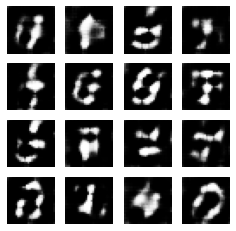

Time for epoch 2 is 11.218736410140991 sec
discriminator loss: -4.49995
generator loss: -1.58686


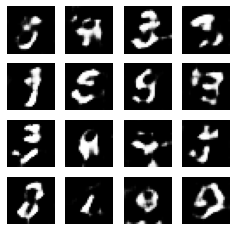

Time for epoch 3 is 11.298386096954346 sec
discriminator loss: -4.56566
generator loss: 1.31000


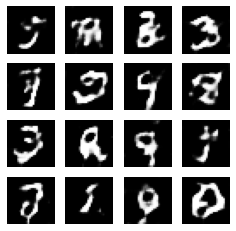

Time for epoch 4 is 11.408545970916748 sec
discriminator loss: -4.04698
generator loss: -4.00017


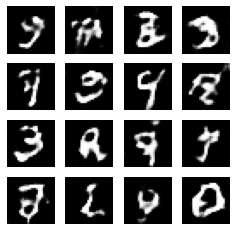

Time for epoch 5 is 11.46903681755066 sec
discriminator loss: -3.82075
generator loss: -7.03838


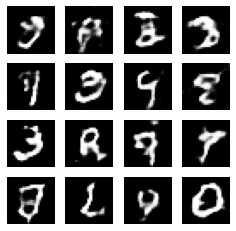

Time for epoch 6 is 11.512901067733765 sec
discriminator loss: -3.13288
generator loss: -8.37803


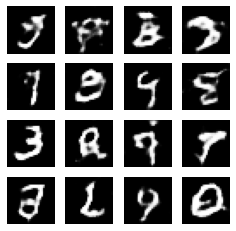

Time for epoch 7 is 11.56023621559143 sec
discriminator loss: -2.97872
generator loss: -7.11495


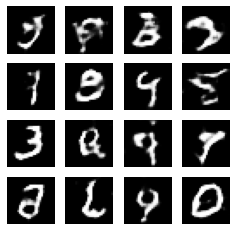

Time for epoch 8 is 11.628572702407837 sec
discriminator loss: -2.73156
generator loss: -6.40122


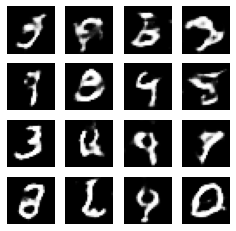

Time for epoch 9 is 11.89234733581543 sec
discriminator loss: -2.39314
generator loss: -6.22916


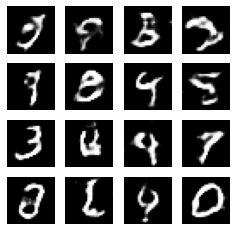

Time for epoch 10 is 11.937981843948364 sec
discriminator loss: -2.30727
generator loss: -6.07649


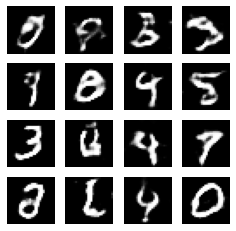

Time for epoch 11 is 12.033102989196777 sec
discriminator loss: -2.70494
generator loss: -3.25555


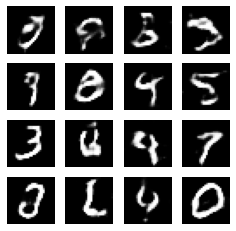

Time for epoch 12 is 12.039981842041016 sec
discriminator loss: -2.10724
generator loss: -5.85171


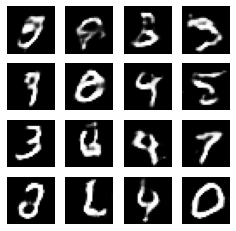

Time for epoch 13 is 12.056203842163086 sec
discriminator loss: -2.64566
generator loss: -4.38991


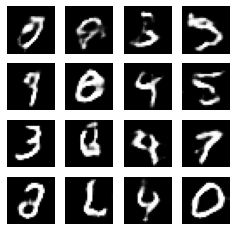

Time for epoch 14 is 12.10431957244873 sec
discriminator loss: -2.42165
generator loss: -4.05302


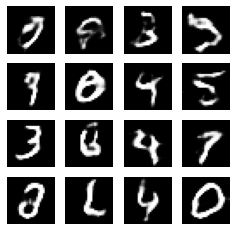

Time for epoch 15 is 12.147827386856079 sec
discriminator loss: -2.54526
generator loss: -4.45822


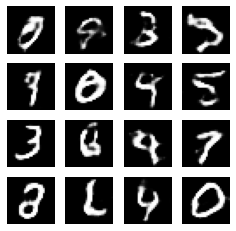

Time for epoch 16 is 12.137605905532837 sec
discriminator loss: -1.88826
generator loss: -5.25084


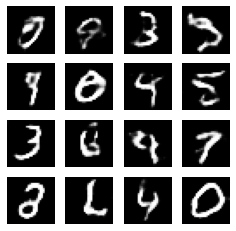

Time for epoch 17 is 12.151318788528442 sec
discriminator loss: -2.70904
generator loss: -5.79918


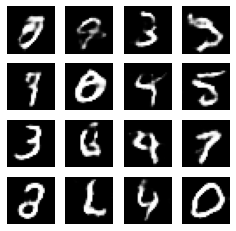

Time for epoch 18 is 12.195353984832764 sec
discriminator loss: -2.74687
generator loss: -5.48121


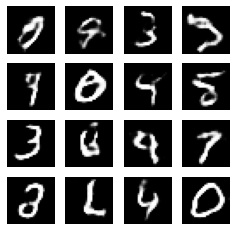

Time for epoch 19 is 12.216835975646973 sec
discriminator loss: -1.95368
generator loss: -6.20986


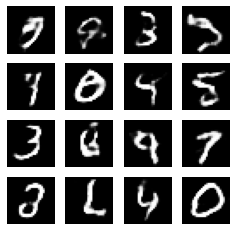

Time for epoch 20 is 12.162862777709961 sec
discriminator loss: -2.69156
generator loss: -5.81276


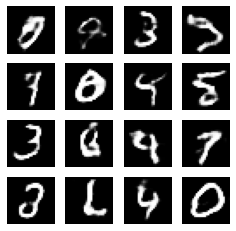

Time for epoch 21 is 12.234222173690796 sec
discriminator loss: -2.58329
generator loss: -5.24099


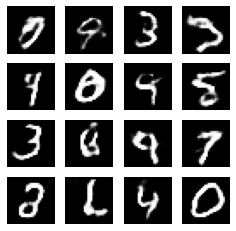

Time for epoch 22 is 12.233917474746704 sec
discriminator loss: -2.32944
generator loss: -5.24268


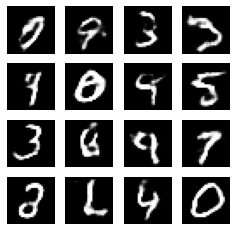

Time for epoch 23 is 12.184905290603638 sec
discriminator loss: -2.42678
generator loss: -4.93972


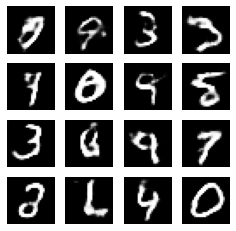

Time for epoch 24 is 12.23672866821289 sec
discriminator loss: -2.60561
generator loss: -4.47887


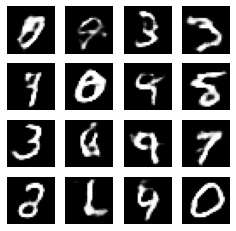

Time for epoch 25 is 12.251907110214233 sec
discriminator loss: -2.74736
generator loss: -6.14295


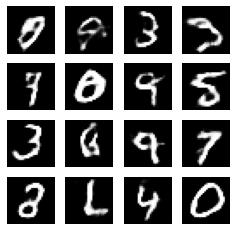

Time for epoch 26 is 12.12237548828125 sec
discriminator loss: -2.37857
generator loss: -5.04005


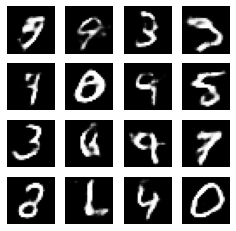

Time for epoch 27 is 12.227948904037476 sec
discriminator loss: -2.54288
generator loss: -4.70757


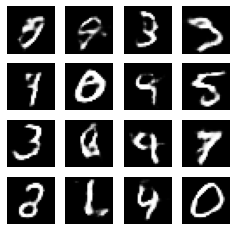

Time for epoch 28 is 12.255878686904907 sec
discriminator loss: -2.21878
generator loss: -6.44172


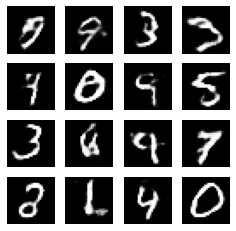

Time for epoch 29 is 12.267141819000244 sec
discriminator loss: -2.36975
generator loss: -5.29804


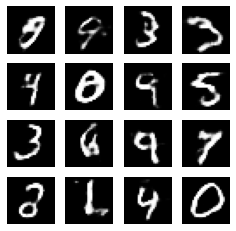

Time for epoch 30 is 12.18971848487854 sec
discriminator loss: -2.73933
generator loss: -4.73846


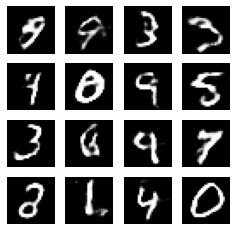

Time for epoch 31 is 12.26763916015625 sec
discriminator loss: -2.21334
generator loss: -5.16780


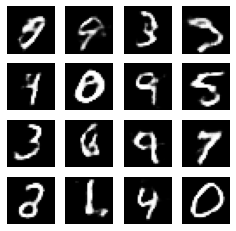

Time for epoch 32 is 12.246930599212646 sec
discriminator loss: -2.37024
generator loss: -5.26691


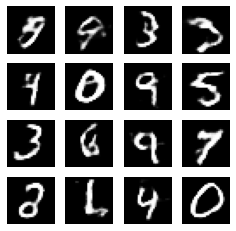

Time for epoch 33 is 12.243303060531616 sec
discriminator loss: -2.49713
generator loss: -5.53944


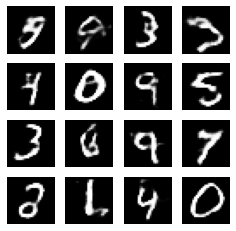

Time for epoch 34 is 12.248432159423828 sec
discriminator loss: -2.97080
generator loss: -4.78840


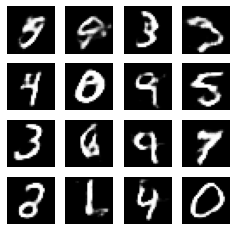

Time for epoch 35 is 12.274440288543701 sec
discriminator loss: -2.52489
generator loss: -4.83186


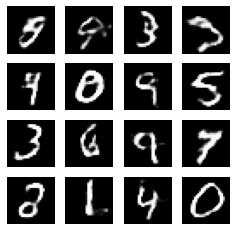

Time for epoch 36 is 12.2773597240448 sec
discriminator loss: -2.59359
generator loss: -4.64930


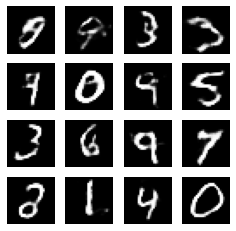

Time for epoch 37 is 12.219970703125 sec
discriminator loss: -2.03871
generator loss: -5.22788


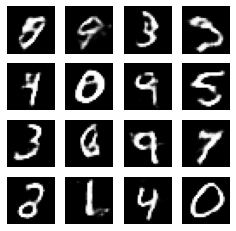

Time for epoch 38 is 12.285372972488403 sec
discriminator loss: -2.29870
generator loss: -4.74145


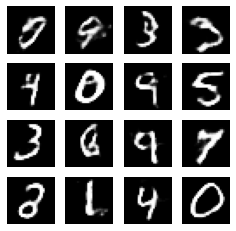

Time for epoch 39 is 12.28978705406189 sec
discriminator loss: -2.22082
generator loss: -5.44494


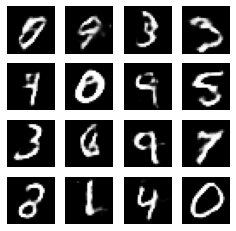

Time for epoch 40 is 12.21242356300354 sec
discriminator loss: -2.20603
generator loss: -4.64367


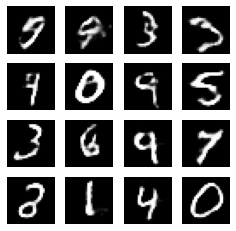

Time for epoch 41 is 12.275327205657959 sec
discriminator loss: -2.51393
generator loss: -4.91632


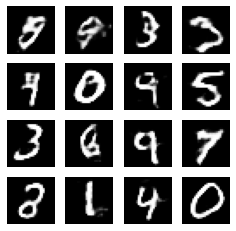

Time for epoch 42 is 12.274121761322021 sec
discriminator loss: -2.41504
generator loss: -5.34400


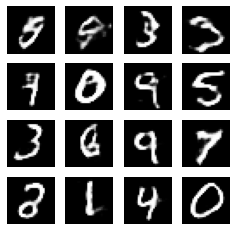

Time for epoch 43 is 12.221150398254395 sec
discriminator loss: -1.86163
generator loss: -4.37354


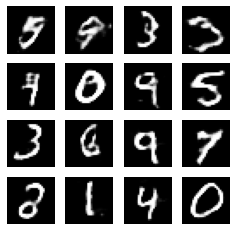

Time for epoch 44 is 12.290271997451782 sec
discriminator loss: -2.16704
generator loss: -4.79283


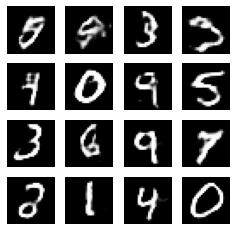

Time for epoch 45 is 12.265340089797974 sec
discriminator loss: -2.53664
generator loss: -4.01010


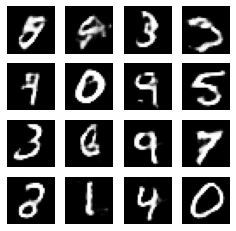

Time for epoch 46 is 12.274678707122803 sec
discriminator loss: -1.91457
generator loss: -4.61334


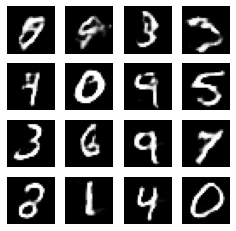

Time for epoch 47 is 12.266108989715576 sec
discriminator loss: -1.71954
generator loss: -4.86754


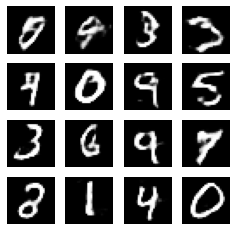

Time for epoch 48 is 12.282117128372192 sec
discriminator loss: -1.83223
generator loss: -4.58954


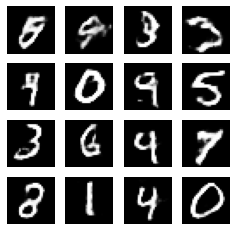

Time for epoch 49 is 12.278662204742432 sec
discriminator loss: -2.48834
generator loss: -3.89116


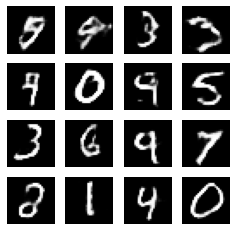

Time for epoch 50 is 12.232179403305054 sec
discriminator loss: -2.17660
generator loss: -4.34893


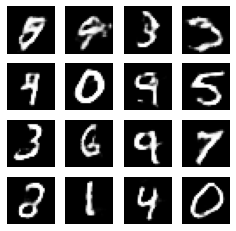

Time for epoch 51 is 12.177219867706299 sec
discriminator loss: -1.94461
generator loss: -3.54755


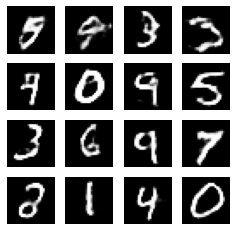

Time for epoch 52 is 12.26204538345337 sec
discriminator loss: -1.95410
generator loss: -3.36995


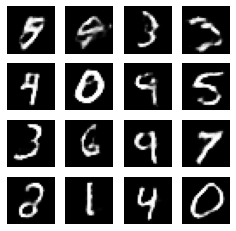

Time for epoch 53 is 12.251072645187378 sec
discriminator loss: -2.03078
generator loss: -3.57611


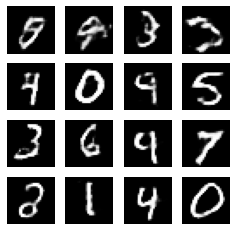

Time for epoch 54 is 12.298816442489624 sec
discriminator loss: -1.94095
generator loss: -3.35406


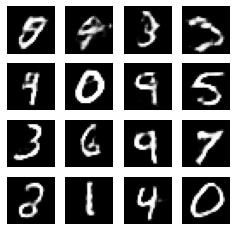

Time for epoch 55 is 12.274751901626587 sec
discriminator loss: -2.20150
generator loss: -3.44825


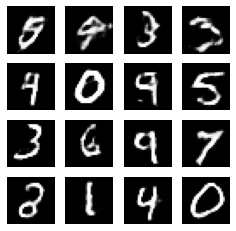

Time for epoch 56 is 12.254446506500244 sec
discriminator loss: -2.19483
generator loss: -2.42076


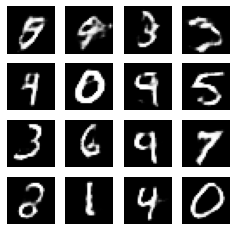

Time for epoch 57 is 12.264507055282593 sec
discriminator loss: -1.52438
generator loss: -3.44804


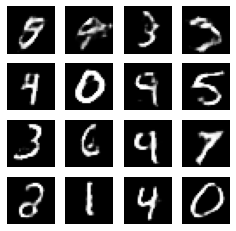

Time for epoch 58 is 12.278109073638916 sec
discriminator loss: -1.80626
generator loss: -3.69150


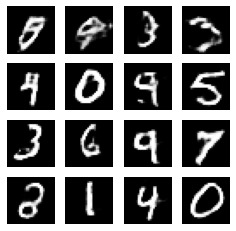

Time for epoch 59 is 12.266165256500244 sec
discriminator loss: -2.10762
generator loss: -3.14129


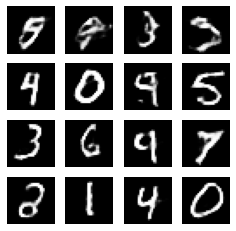

Time for epoch 60 is 12.247185230255127 sec
discriminator loss: -1.74782
generator loss: -3.59384


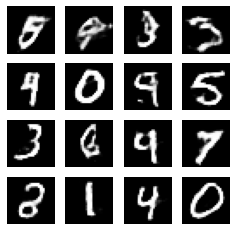

Time for epoch 61 is 12.307289838790894 sec
discriminator loss: -2.05573
generator loss: -2.35608


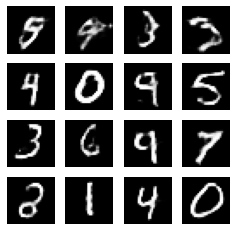

Time for epoch 62 is 12.31194281578064 sec
discriminator loss: -2.04252
generator loss: -2.17220


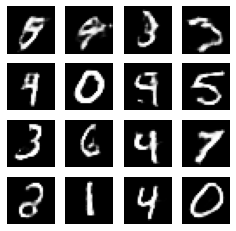

Time for epoch 63 is 12.255955696105957 sec
discriminator loss: -2.15834
generator loss: -2.50014


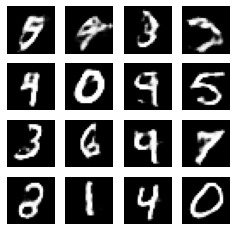

Time for epoch 64 is 12.29414701461792 sec
discriminator loss: -2.36536
generator loss: -1.78400


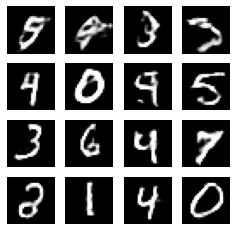

Time for epoch 65 is 12.277149200439453 sec
discriminator loss: -1.82620
generator loss: -2.92298


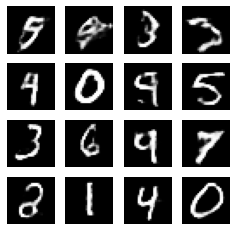

Time for epoch 66 is 12.302050828933716 sec
discriminator loss: -1.96914
generator loss: -1.95590


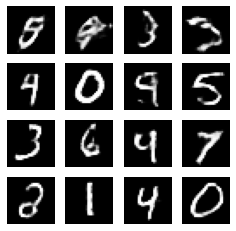

Time for epoch 67 is 12.267117977142334 sec
discriminator loss: -2.48293
generator loss: -1.28395


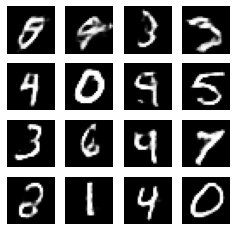

Time for epoch 68 is 12.28256630897522 sec
discriminator loss: -1.76481
generator loss: -1.77119


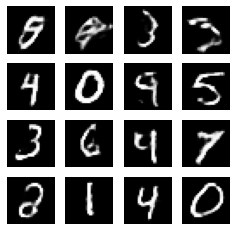

Time for epoch 69 is 12.30353832244873 sec
discriminator loss: -1.77572
generator loss: -2.66025


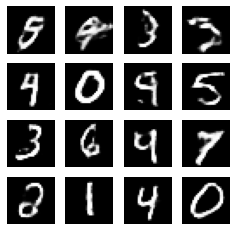

Time for epoch 70 is 12.256441116333008 sec
discriminator loss: -2.11494
generator loss: -1.56789


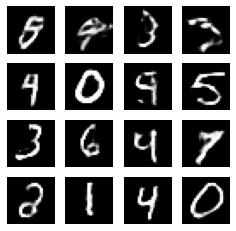

Time for epoch 71 is 12.29205584526062 sec
discriminator loss: -1.50020
generator loss: -1.42055


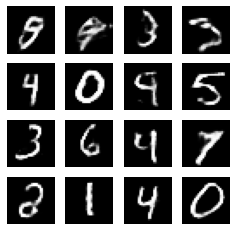

Time for epoch 72 is 12.314383506774902 sec
discriminator loss: -2.54919
generator loss: -0.44818


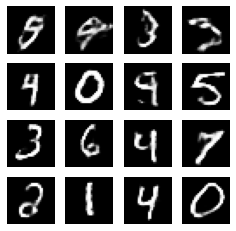

Time for epoch 73 is 12.27492070198059 sec
discriminator loss: -1.62415
generator loss: -2.48138


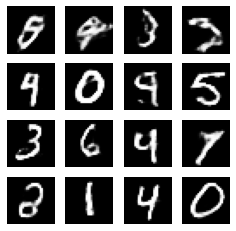

Time for epoch 74 is 12.279966115951538 sec
discriminator loss: -2.36529
generator loss: -0.08109


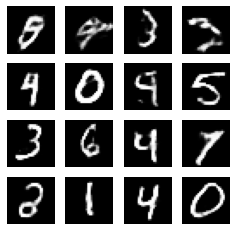

Time for epoch 75 is 12.30248236656189 sec
discriminator loss: -2.27137
generator loss: -1.76386


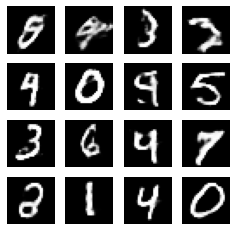

Time for epoch 76 is 12.182325601577759 sec
discriminator loss: -2.26178
generator loss: -1.32148


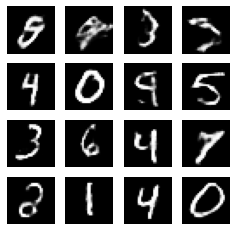

Time for epoch 77 is 12.249802112579346 sec
discriminator loss: -0.88034
generator loss: -1.43315


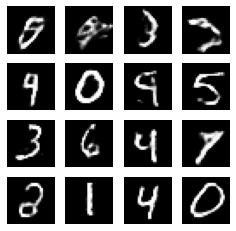

Time for epoch 78 is 12.325631618499756 sec
discriminator loss: -1.64663
generator loss: -1.06779


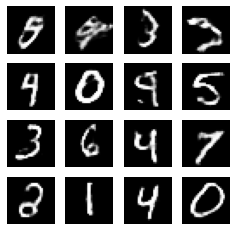

Time for epoch 79 is 12.300090074539185 sec
discriminator loss: -2.34513
generator loss: -0.19428


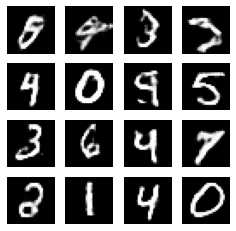

Time for epoch 80 is 12.259151220321655 sec
discriminator loss: -1.95576
generator loss: -0.16861


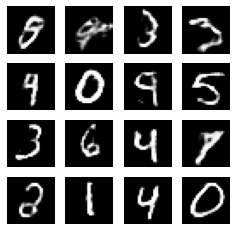

Time for epoch 81 is 12.30819845199585 sec
discriminator loss: -1.75443
generator loss: -1.67448


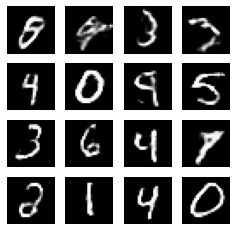

Time for epoch 82 is 12.309355735778809 sec
discriminator loss: -0.80897
generator loss: -2.80310


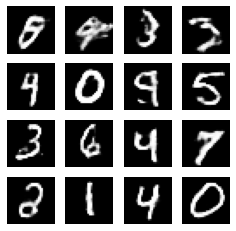

Time for epoch 83 is 12.26829743385315 sec
discriminator loss: -1.65368
generator loss: -2.06777


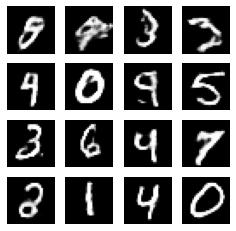

Time for epoch 84 is 12.27843713760376 sec
discriminator loss: -2.28978
generator loss: -0.33609


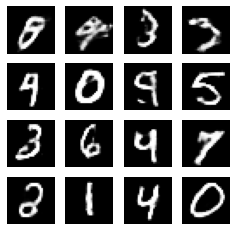

Time for epoch 85 is 12.269855976104736 sec
discriminator loss: -2.07421
generator loss: -1.01978


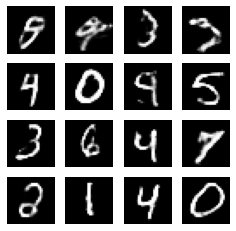

Time for epoch 86 is 12.316497564315796 sec
discriminator loss: -2.36073
generator loss: -1.19460


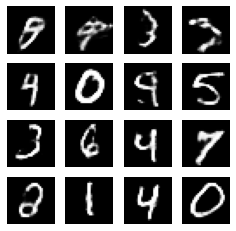

Time for epoch 87 is 12.256168603897095 sec
discriminator loss: -1.52024
generator loss: -1.72249


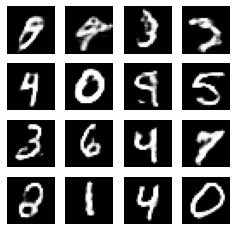

Time for epoch 88 is 12.266633749008179 sec
discriminator loss: -1.72595
generator loss: -0.78792


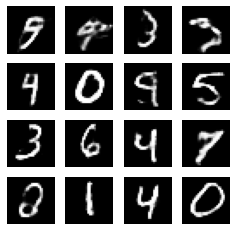

Time for epoch 89 is 12.302577257156372 sec
discriminator loss: -1.93393
generator loss: -1.17915


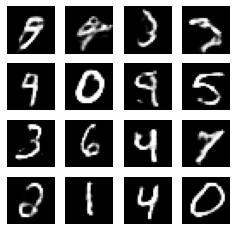

Time for epoch 90 is 12.247483730316162 sec
discriminator loss: -2.12681
generator loss: 0.04697


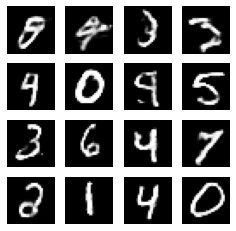

Time for epoch 91 is 12.269304275512695 sec
discriminator loss: -2.32343
generator loss: -1.13546


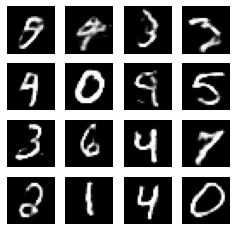

Time for epoch 92 is 12.290366172790527 sec
discriminator loss: -1.73492
generator loss: -1.67816


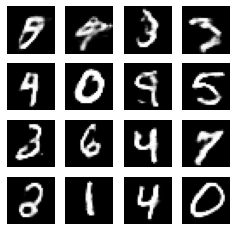

Time for epoch 93 is 12.249389886856079 sec
discriminator loss: -1.39805
generator loss: 0.48657


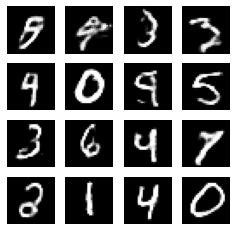

Time for epoch 94 is 12.288942098617554 sec
discriminator loss: -1.93244
generator loss: -2.12847


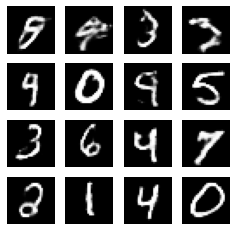

Time for epoch 95 is 12.312596559524536 sec
discriminator loss: -1.28673
generator loss: -2.56478


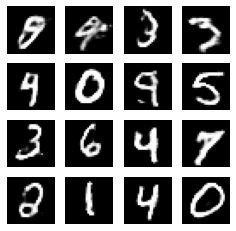

Time for epoch 96 is 12.264376640319824 sec
discriminator loss: -2.41294
generator loss: -0.53450


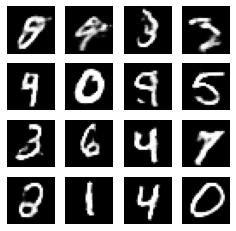

Time for epoch 97 is 12.252743244171143 sec
discriminator loss: -2.37663
generator loss: -1.70343


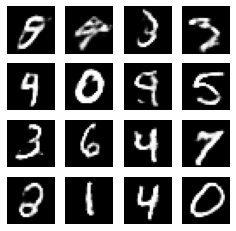

Time for epoch 98 is 12.272454738616943 sec
discriminator loss: -1.55721
generator loss: -2.14134


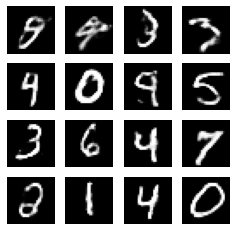

Time for epoch 99 is 12.282106637954712 sec
discriminator loss: -2.09106
generator loss: -1.09513


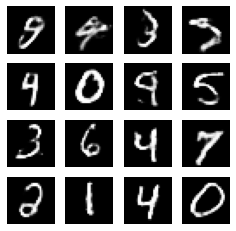

Time for epoch 100 is 12.303138732910156 sec
discriminator loss: -1.63457
generator loss: -0.47154


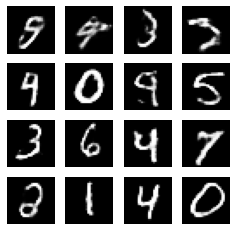

Time for epoch 101 is 12.218377828598022 sec
discriminator loss: -2.33166
generator loss: -2.32050


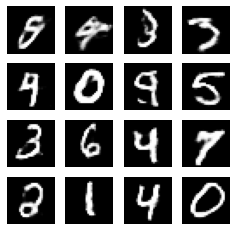

Time for epoch 102 is 12.28860068321228 sec
discriminator loss: -1.35281
generator loss: -2.14507


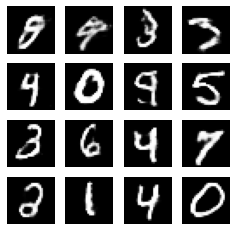

Time for epoch 103 is 12.256181001663208 sec
discriminator loss: -1.31068
generator loss: 0.08228


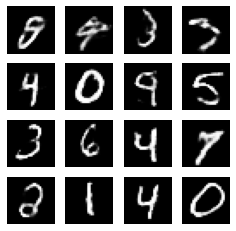

Time for epoch 104 is 12.26635193824768 sec
discriminator loss: -1.45249
generator loss: -0.09290


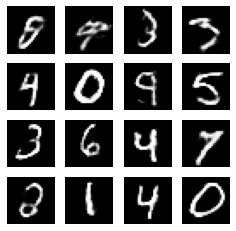

Time for epoch 105 is 12.327597618103027 sec
discriminator loss: -1.95853
generator loss: 0.52315


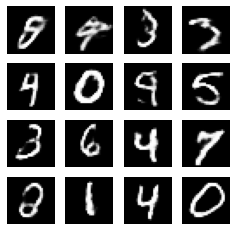

Time for epoch 106 is 12.310865640640259 sec
discriminator loss: -1.48313
generator loss: -0.53998


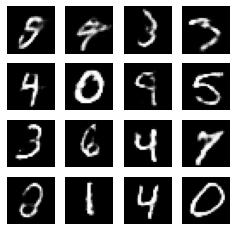

Time for epoch 107 is 12.224437952041626 sec
discriminator loss: -1.49411
generator loss: -1.15472


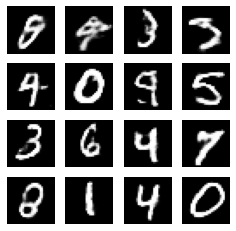

Time for epoch 108 is 12.27007269859314 sec
discriminator loss: -2.06510
generator loss: 1.48128


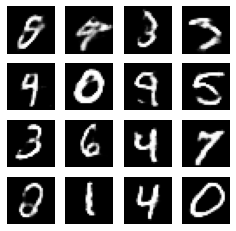

Time for epoch 109 is 12.307865142822266 sec
discriminator loss: -2.28755
generator loss: 1.36144


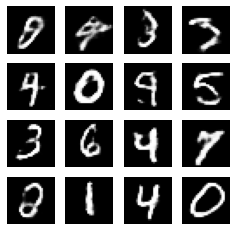

Time for epoch 110 is 12.230098485946655 sec
discriminator loss: -2.06210
generator loss: 2.53734


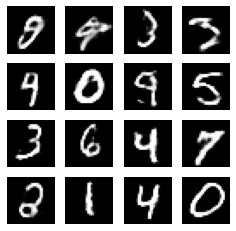

Time for epoch 111 is 12.253331422805786 sec
discriminator loss: -2.45215
generator loss: -1.08655


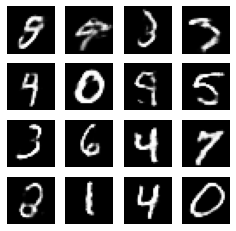

Time for epoch 112 is 12.352550268173218 sec
discriminator loss: -1.95608
generator loss: 0.95462


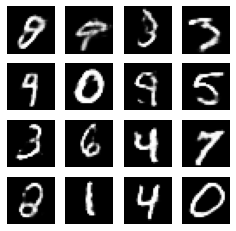

Time for epoch 113 is 12.242400407791138 sec
discriminator loss: -1.20133
generator loss: 1.96933


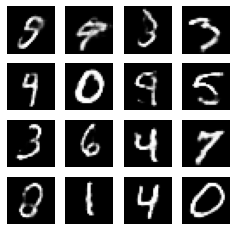

Time for epoch 114 is 12.256966352462769 sec
discriminator loss: -1.68533
generator loss: -1.65202


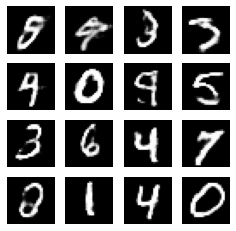

Time for epoch 115 is 12.280783653259277 sec
discriminator loss: -1.58448
generator loss: 0.92351


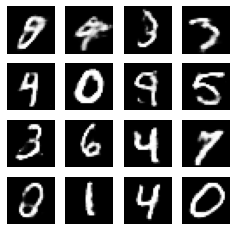

Time for epoch 116 is 12.259326219558716 sec
discriminator loss: -1.24558
generator loss: -0.73199


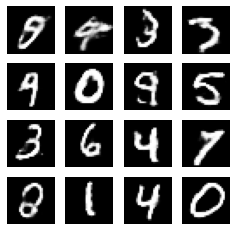

Time for epoch 117 is 12.264715909957886 sec
discriminator loss: -1.82884
generator loss: 1.76959


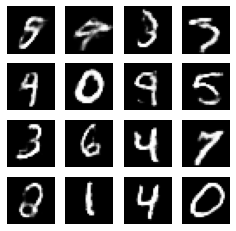

Time for epoch 118 is 12.29168438911438 sec
discriminator loss: -2.53185
generator loss: -1.22282


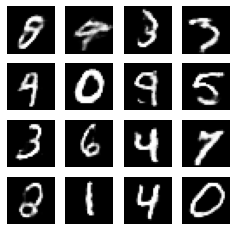

Time for epoch 119 is 12.290708780288696 sec
discriminator loss: -1.75420
generator loss: -0.13445


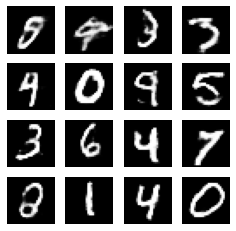

Time for epoch 120 is 12.202878952026367 sec
discriminator loss: -1.87405
generator loss: -1.22653


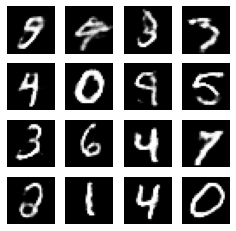

Time for epoch 121 is 12.258080959320068 sec
discriminator loss: -1.60742
generator loss: -1.84667


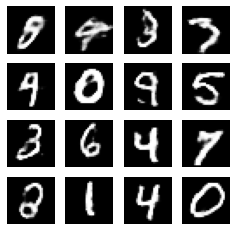

Time for epoch 122 is 12.26478362083435 sec
discriminator loss: -1.88769
generator loss: 2.43212


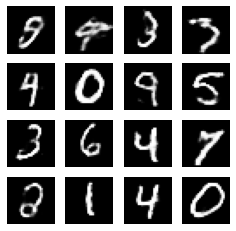

Time for epoch 123 is 12.234548807144165 sec
discriminator loss: -1.71729
generator loss: 1.72847


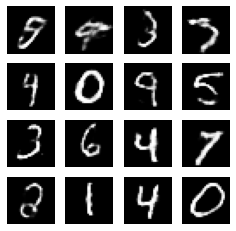

Time for epoch 124 is 12.253637075424194 sec
discriminator loss: -1.56921
generator loss: 1.05335


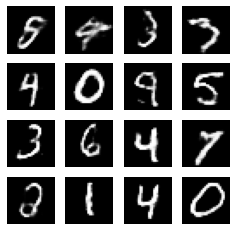

Time for epoch 125 is 12.278790473937988 sec
discriminator loss: -1.96942
generator loss: 0.72882


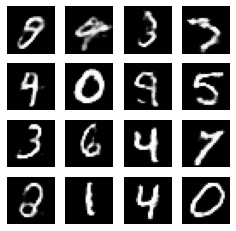

Time for epoch 126 is 12.177793502807617 sec
discriminator loss: -1.59188
generator loss: -0.35323


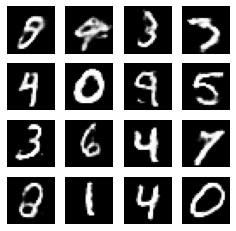

Time for epoch 127 is 12.239310503005981 sec
discriminator loss: -2.73393
generator loss: -0.12722


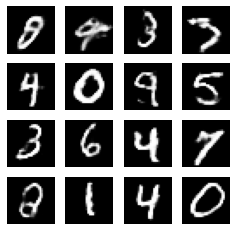

Time for epoch 128 is 12.24309778213501 sec
discriminator loss: -1.36536
generator loss: -0.60708


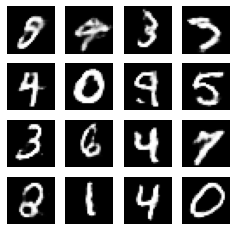

Time for epoch 129 is 12.281452894210815 sec
discriminator loss: -1.66013
generator loss: 2.38193


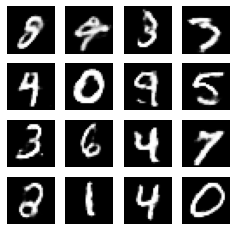

Time for epoch 130 is 12.186158180236816 sec
discriminator loss: -2.20746
generator loss: 5.11202


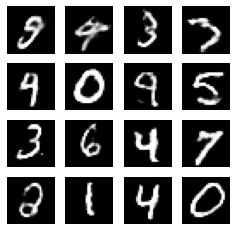

Time for epoch 131 is 12.266738653182983 sec
discriminator loss: -1.34043
generator loss: 1.03229


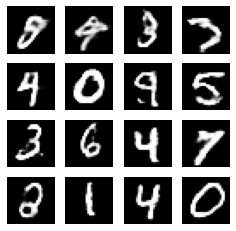

Time for epoch 132 is 12.271781921386719 sec
discriminator loss: -2.07568
generator loss: 2.01082


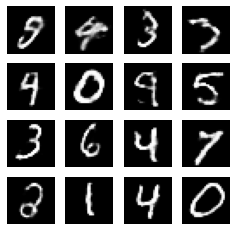

Time for epoch 133 is 12.220771312713623 sec
discriminator loss: -2.14709
generator loss: 3.28735


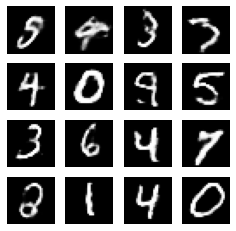

Time for epoch 134 is 12.253236770629883 sec
discriminator loss: -1.74160
generator loss: 1.46342


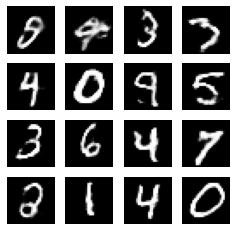

Time for epoch 135 is 12.236502885818481 sec
discriminator loss: -1.51255
generator loss: 1.85258


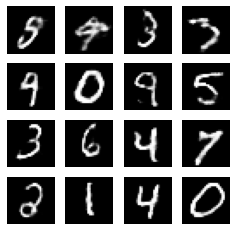

Time for epoch 136 is 12.256283044815063 sec
discriminator loss: -1.81154
generator loss: 0.92972


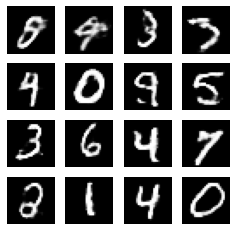

Time for epoch 137 is 12.243383169174194 sec
discriminator loss: -1.93671
generator loss: 2.06864


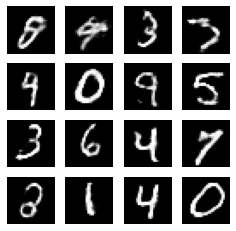

Time for epoch 138 is 12.283352613449097 sec
discriminator loss: -1.93529
generator loss: 2.00012


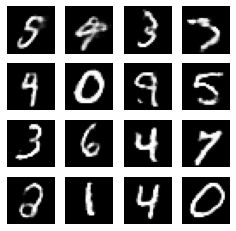

Time for epoch 139 is 12.203067064285278 sec
discriminator loss: -1.89131
generator loss: 2.58851


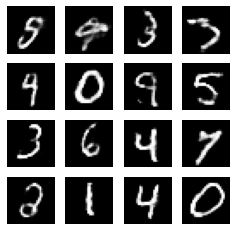

Time for epoch 140 is 12.341043472290039 sec
discriminator loss: -1.18142
generator loss: 2.06068


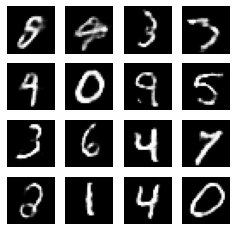

Time for epoch 141 is 12.214834213256836 sec
discriminator loss: -2.21035
generator loss: 2.61633


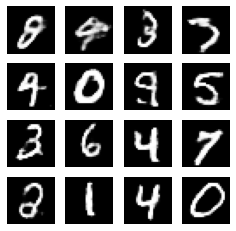

Time for epoch 142 is 12.236533403396606 sec
discriminator loss: -1.45090
generator loss: 0.85704


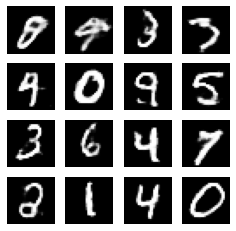

Time for epoch 143 is 12.254334449768066 sec
discriminator loss: -1.52240
generator loss: 2.26768


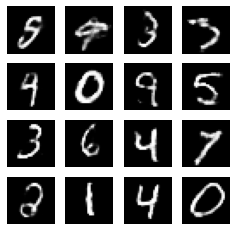

Time for epoch 144 is 12.291804075241089 sec
discriminator loss: -1.57787
generator loss: 1.57278


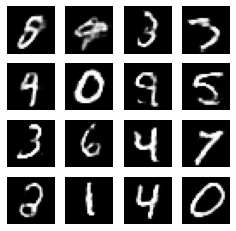

Time for epoch 145 is 12.254170656204224 sec
discriminator loss: -1.52099
generator loss: 2.21466


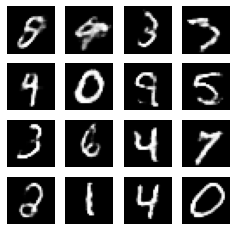

Time for epoch 146 is 12.290783643722534 sec
discriminator loss: -1.67281
generator loss: 1.39121


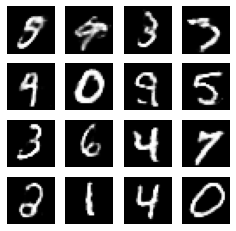

Time for epoch 147 is 12.244950294494629 sec
discriminator loss: -1.92046
generator loss: 2.21946


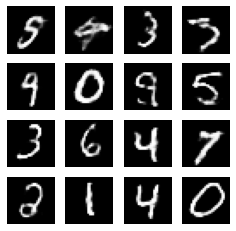

Time for epoch 148 is 12.279143333435059 sec
discriminator loss: -1.55009
generator loss: 2.06188


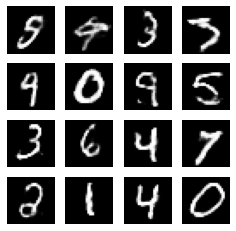

Time for epoch 149 is 12.269632816314697 sec
discriminator loss: -1.62641
generator loss: 0.30031


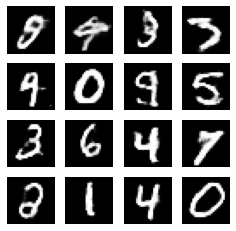

Time for epoch 150 is 12.209413766860962 sec
discriminator loss: -1.80904
generator loss: 0.52877


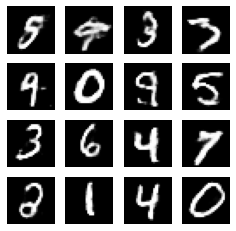

Time for epoch 151 is 12.200496196746826 sec
discriminator loss: -1.58765
generator loss: 1.57342


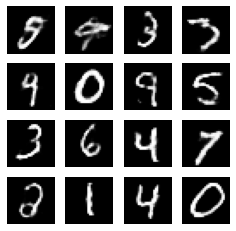

Time for epoch 152 is 12.269981145858765 sec
discriminator loss: -1.60905
generator loss: 0.14824


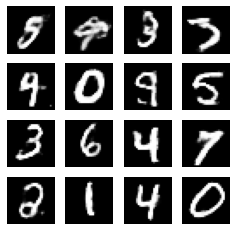

Time for epoch 153 is 12.237130641937256 sec
discriminator loss: -2.12351
generator loss: 2.41367


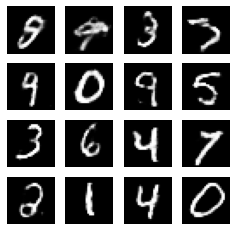

Time for epoch 154 is 12.254057168960571 sec
discriminator loss: -1.87126
generator loss: 1.58669


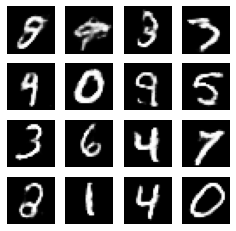

Time for epoch 155 is 12.279695272445679 sec
discriminator loss: -2.62698
generator loss: 2.12930


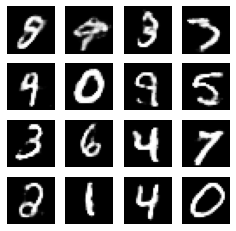

Time for epoch 156 is 12.300780773162842 sec
discriminator loss: -1.35471
generator loss: 1.64435


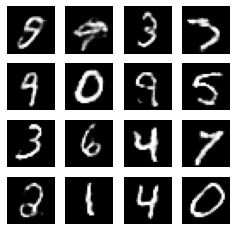

Time for epoch 157 is 12.246415138244629 sec
discriminator loss: -1.85419
generator loss: 1.86128


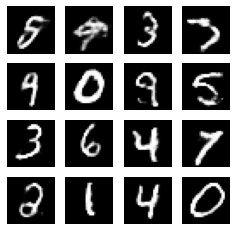

Time for epoch 158 is 12.281530857086182 sec
discriminator loss: -1.80168
generator loss: 1.14237


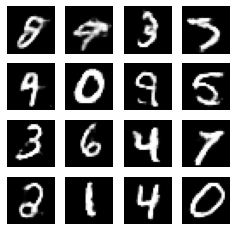

Time for epoch 159 is 12.23901104927063 sec
discriminator loss: -2.07008
generator loss: 1.67554


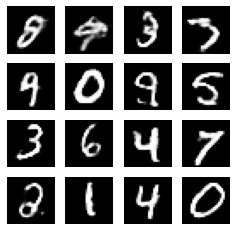

Time for epoch 160 is 12.239261150360107 sec
discriminator loss: -1.40322
generator loss: 1.67321


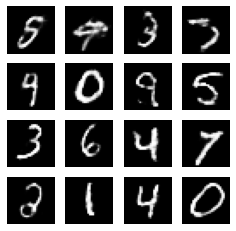

Time for epoch 161 is 12.301406383514404 sec
discriminator loss: -1.56810
generator loss: 1.45861


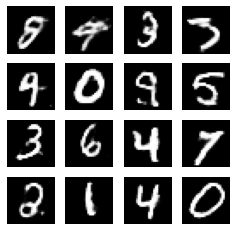

Time for epoch 162 is 12.265127420425415 sec
discriminator loss: -2.14180
generator loss: 1.50902


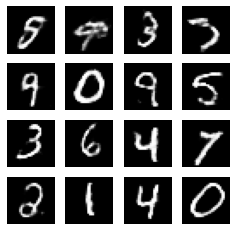

Time for epoch 163 is 12.232066631317139 sec
discriminator loss: -1.78877
generator loss: 1.36657


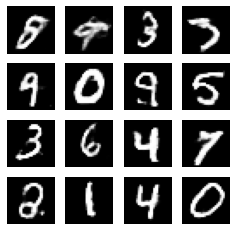

Time for epoch 164 is 12.286199569702148 sec
discriminator loss: -1.11177
generator loss: 2.79598


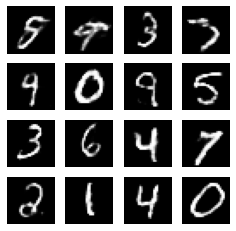

Time for epoch 165 is 12.273499965667725 sec
discriminator loss: -2.01775
generator loss: 1.15409


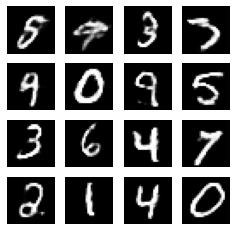

Time for epoch 166 is 12.271806716918945 sec
discriminator loss: -1.70070
generator loss: 1.66171


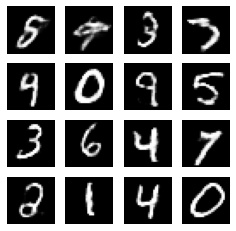

Time for epoch 167 is 12.251556396484375 sec
discriminator loss: -1.43925
generator loss: 0.74285


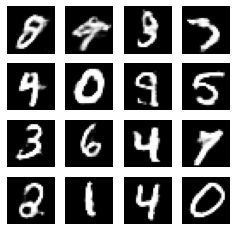

Time for epoch 168 is 12.280151844024658 sec
discriminator loss: -1.27826
generator loss: 2.47927


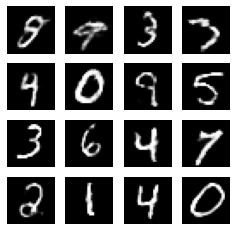

Time for epoch 169 is 12.268766641616821 sec
discriminator loss: -2.05013
generator loss: 2.75146


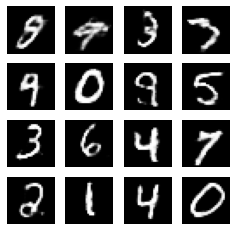

Time for epoch 170 is 12.206850051879883 sec
discriminator loss: -2.00848
generator loss: 1.63577


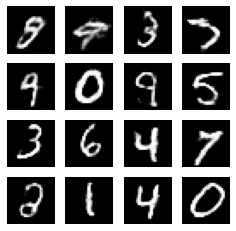

Time for epoch 171 is 12.295064687728882 sec
discriminator loss: -1.99396
generator loss: 0.87626


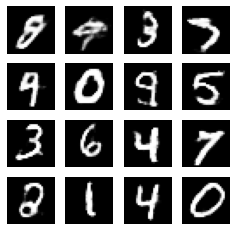

Time for epoch 172 is 12.275032997131348 sec
discriminator loss: -1.61217
generator loss: 1.46780


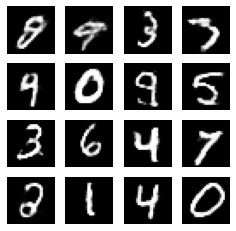

Time for epoch 173 is 12.257879257202148 sec
discriminator loss: -1.91466
generator loss: 0.83341


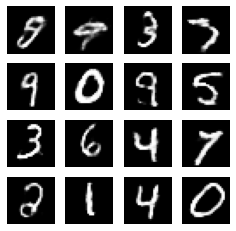

Time for epoch 174 is 12.279502391815186 sec
discriminator loss: -2.01667
generator loss: 1.34470


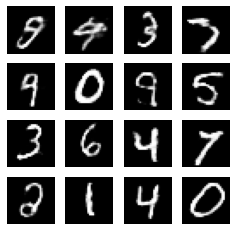

Time for epoch 175 is 12.270992755889893 sec
discriminator loss: -1.46967
generator loss: 0.81780


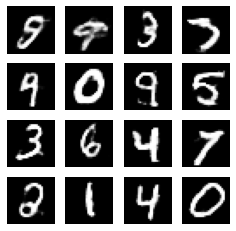

Time for epoch 176 is 12.172013282775879 sec
discriminator loss: -2.10845
generator loss: 2.06341


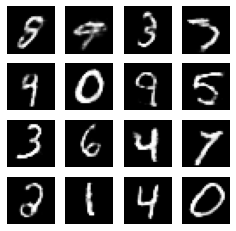

Time for epoch 177 is 12.28217601776123 sec
discriminator loss: -1.52774
generator loss: 0.81717


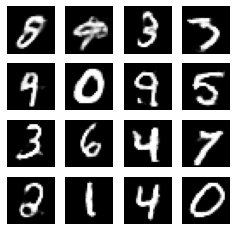

Time for epoch 178 is 12.271120309829712 sec
discriminator loss: -1.58577
generator loss: 1.00889


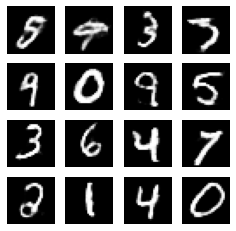

Time for epoch 179 is 12.288562536239624 sec
discriminator loss: -1.30749
generator loss: 0.33738


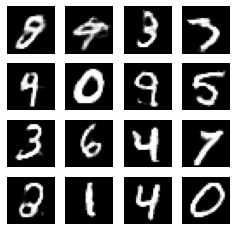

Time for epoch 180 is 12.272590160369873 sec
discriminator loss: -1.70886
generator loss: 0.70186


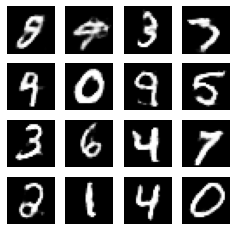

Time for epoch 181 is 12.27391791343689 sec
discriminator loss: -1.62217
generator loss: -0.43161


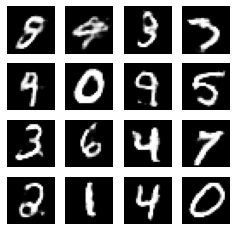

Time for epoch 182 is 12.260010242462158 sec
discriminator loss: -1.34125
generator loss: 0.05399


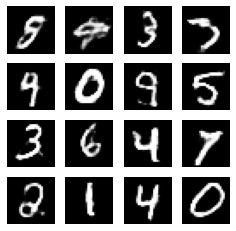

Time for epoch 183 is 12.299606561660767 sec
discriminator loss: -1.80656
generator loss: 0.19099


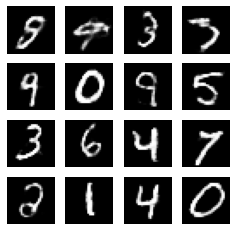

Time for epoch 184 is 12.26225733757019 sec
discriminator loss: -1.79048
generator loss: 0.10695


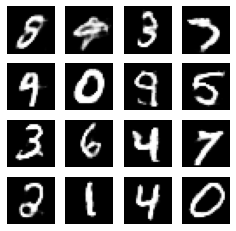

Time for epoch 185 is 12.268018007278442 sec
discriminator loss: -2.10621
generator loss: 0.57102


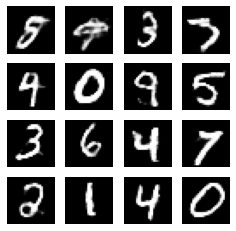

Time for epoch 186 is 12.277782678604126 sec
discriminator loss: -1.68466
generator loss: -1.02793


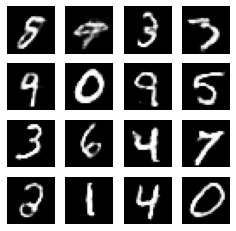

Time for epoch 187 is 12.29027771949768 sec
discriminator loss: -2.79221
generator loss: 0.48524


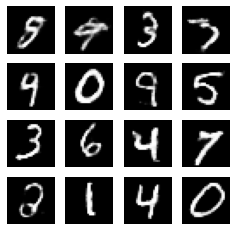

Time for epoch 188 is 12.295881032943726 sec
discriminator loss: -2.21763
generator loss: -0.18338


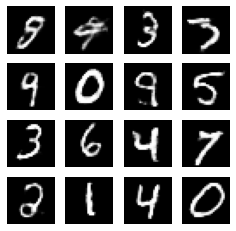

Time for epoch 189 is 12.303887367248535 sec
discriminator loss: -1.53990
generator loss: 0.45976


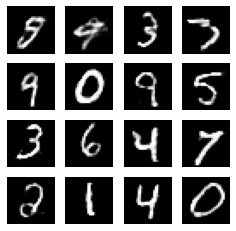

Time for epoch 190 is 12.231264591217041 sec
discriminator loss: -1.83103
generator loss: 0.02616


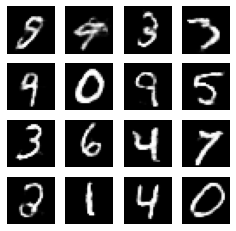

Time for epoch 191 is 12.293994426727295 sec
discriminator loss: -1.83041
generator loss: -0.94501


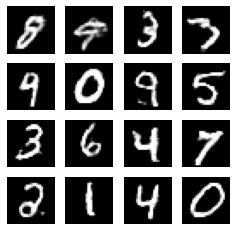

In [ ]:
%%time
train(train_dataset, EPOCHS)

In [ ]:
# 使用imageio製作gif圖
anim_file = 'saved_imgs_GP/wgan-gp.gif'

with imageio.get_writer(anim_file, mode='I') as writer:

    filenames = glob.glob('saved_imgs_GP/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

display(Image(filename=anim_file))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
noise = tf.random.normal([1, z_dim])
img = generator(noise)

plt.imshow(img[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')
plt.show()